In [108]:
# !pip install keras-buoy
import shutil
import matplotlib.pyplot as plt
from datetime import date, datetime
from random import shuffle

import csv
from csv import writer
import numpy as np
import os
import cv2
import tensorflow as tf
from keras.utils.layer_utils import count_params
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
# from keras_buoy.models import ResumableModel


In [127]:
########################################################################
# Hauptverzeichnisse festlegen (Google Colab)
########################################################################
# Lädt Google Drive
from google.colab import drive
drive.mount('/content/drive')


###############################################
# Quellpfade zum Einlesen der Bilder und Labels
###############################################
srcpath_images = "/content/drive/My Drive/Bilddaten/"
srcpath_label_infos = "/content/drive/My Drive/Wand_Label_Infos/"
# Wie heißt die CSV Datei in der die Labelinfos gespeichert sind
csv_name = "Wand_Label_Info7.csv"
# Spalte in der CSV Datei in der die Labelinfos über die 
# Spachtelmasse (putty) gespeichert sind. 
# Achtung counter beginnt mit 0
csv_spalte_labelinfo_putty = 23


###############################################
# Gibt die Nummer des Trainings an
###############################################
# Achtung! Nummer des Trainings nicht wiederverwenden
numberoftraining = 3


###############################################
# Gibt den Zielpfad für Infos des Trainings an
###############################################
destpath_dir = "/content/drive/My Drive/Training/Training" + str(numberoftraining) + "/"
# Gibt die Pfade zum Zwischenspeichern der verwendeten Bilder an
# VORSICHT! ORDNER WERDEN BEIM START DES SKRIPTS GELÖSCHT/GELEERT!
destpath_train_images = destpath_dir + "Dataset/Trainingset/"
destpath_val_images = destpath_dir + "Dataset/Validationset/"
destpath_test_images = destpath_dir + "Dataset/Testset/"
# Gibt den Pfad zum speichern des trainierten Modells an
destpath_modelsave = destpath_dir + "models/"
# Gibt den Pfad zum Speichern der Modell-Plots an
destpath_plotsave = destpath_dir + "Plot/"
destpath_logsave = destpath_dir + "Logs/"


##################################################
# Gibt den Pfad für die Evaluation an
##################################################
path_eval = "/content/drive/My Drive/Training/Evaluation.csv"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
###################################################################
# Arbeitsverzeichnisse festlegen (Windows)
###################################################################
# Gibt die Pfade zum Einlesen der Bilder und Labels an
srcpath_images = "C:/Users/DanielWeller/Desktop/Testdaten/"
srcpath_label_infos = "C:/Users/DanielWeller/Desktop/Wand_Label_Infos/"
srcpath_predict_images = "C:/Users/DanielWeller/Desktop/Predict/"


# Gibt den Zielpfad an
destpath_dir = "C:/Users/DanielWeller/Desktop/Training1/"

In [16]:
# Anzahl der Bilder im Verzeichnis ausgeben
import os
initial_count = 0
for path in os.listdir(srcpath_images):
    if os.path.isfile(os.path.join(srcpath_images, path)):
        initial_count += 1
print(initial_count)

1011


In [128]:
###################################################################
# Parameter festlegen
###################################################################


####################################################################
# Datum und Uhrzeit des Trainings
####################################################################

today = date.today()
now = datetime.now()
# dd/mm/yyyy
date_of_training = today.strftime("%d/%m/%Y")
time_of_training = now.strftime("%H:%M:%S")



###################################################################
# Parameter zum Training des Modells
###################################################################
# Gibt die Anzahl der Epochen an
epochs_train = 100


###################################################################
# Parameter zum Einlesen der Daten
###################################################################

# Sollen die verwendeten Bilder in Verzeichnisse geschrieben werden?
saving_images_to_dir = False

# Sollen die Bilder Standardisiert werden?
standardizing_images = False

# Soll Preprocessing genutzt werden? Dabei werden die Bilder in s/w
# konvertiert und mit einem Canny Filter die Kanten hervorgehoben
preprocesing_images = False

# Soll die Auflösung der Bilder im Vorfeld angepasst werden?
resizing_images = True
# Werte für die Resize Funktion
# Zukünftige Maße für Querformat festlegen 
widthquer = 400
heightquer = 300
# Zukünftige Maße für Hochformat festlegen 
widthhoch = 300
heighthoch = 400

# In welchem Verhältnis sollen die Daten in Train-/Validationssplit
# aufgeteilt werden?
faktorTrainSplit = 0.8

synthetic = False



##################################################################################
# Methode in der die Parameter definiert werden, welche Bilder verwendet werden sollen
##################################################################################
def ImageIsInFilter(splittedfilename):
    # Welche Images sollen aus dem vorher angegebenen SrcOrdner verwendet werden. Gefiltert wird nach den Flags im Dateinamen
    if (
    # ( (splittedfilename[1] == str(1)) or (splittedfilename[1] == str(2)) ) and
    # Prüft an Stelle 13 des Dateinamens auf das Flag "1". Damit werden nur Bilder geladen die mit dem Smartphone aufgenommen wurden
    (splittedfilename[13] == str(1)) and
    # Prüft an Stelle 14 des Dateinamens auf das Flag "1". Damit werden nur Bilder geladen die im Querformat vorliegen.
    (splittedfilename[14] == str(1)) and
    # Prüft an Stelle 15 des Dateinamens auf das Flag "1", "2", "3" und "4". Damit werden nur Bilder geladen die ohne, mit rotem, einem Aruco oder drei Aruco Sticker aufgenommen wurden.
    (splittedfilename[15] == str(1))
    #( (splittedfilename[15] == str(1)) or (splittedfilename[15] == str(2)) or (splittedfilename[15] == str(3)) or (splittedfilename[15] == str(4)) )
    ):
        return True
    return False



##################################################################################
# Methode zum Anlegen der Ordner (keine Anpassung notwendig!)
##################################################################################
def createDir(path):
    if os.path.exists(path):
        shutil.rmtree(path, ignore_errors=False)
    os.makedirs(path)

In [129]:
###################################################################
# Einlesen der Daten (Bilder und Label) in Arrays
###################################################################

# Hilfslisten und Variablen zur Verteilung des Train-/Testsplits
waende_alle = []
waende_train = []
waende_val = []
waende_test = []
# Arrays für die Images des Train- und Testsplits
x_train_material = []
x_val_material = []
x_test_material = []

# Arrays für die Labels des Trainsplits
y_train_material_putty = []
y_train_material_jointTape = []
y_train_material_cornerProfiles = []
# Arrays für die Labels des Validationsplits
y_val_material_putty = []
y_val_material_jointTape = []
y_val_material_cornerProfiles = []

# Arrays für die Labels des Testsplits
y_test_material = []

# Hilfsarray um die Dateinamen aller verwendeten Bilder zwischenzuspeichern
images_train_filenames = []
images_val_filenames = []
images_test_filenames = []
images_all_filenames = []

# Legt die Ordner Struktur an
createDir(destpath_dir)
if saving_images_to_dir:
  createDir(destpath_train_images)
  createDir(destpath_val_images)
  createDir(destpath_test_images)
createDir(destpath_modelsave)
createDir(destpath_logsave)
createDir(destpath_plotsave)



##################################################################################
# Wand-Label-Info-CSV in NP Array einlesen
##################################################################################
# eventueller Parameter: usecols = (0,1,2,3,4,5,6)
# eventueller Parameter: dtype="int" 

with open(str(srcpath_label_infos)+str(csv_name), encoding="utf-8-sig") as wand_label_info_file:
    wand_label_info = np.loadtxt(wand_label_info_file, delimiter=";", dtype="int")
#print(wand_label_info)





##################################################################################
# Baustellen und Wand ID aus Dateinamen laden um Train/Testsplit auf Wandebene vorzubereiten
##################################################################################
for filename in os.listdir(srcpath_images):
    # Trennt den Filename in den reinen Filename und Extension
    filenameshort, extension = os.path.splitext(filename)
    # Prüft ob Datei .jpg ist
    if extension == ".jpg":
        # Splitted den Dateinamen mit dem Trennoperator "_" und speichert den Inhalt in eine Liste
        splittedfilename = filenameshort.split("_")
        # Speichert die Baustellennummer und Wandnummer zwischen
        img_baustellenID = splittedfilename[1]
        img_wandID = splittedfilename[2]
        img_baustellenUndWandID = img_baustellenID+"_"+img_wandID
        # Welche Images sollen aus dem vorher angegebenen SrcOrdner verwendet werden. Gefiltert wird nach den Flags im Dateinamen
        if (ImageIsInFilter(splittedfilename)):
            if img_baustellenUndWandID not in waende_alle:
                waende_alle.append(img_baustellenUndWandID)
waende_alle_count = len(waende_alle)          
print("Anzahl aller verwendeten Wände/Szenen: "+str(waende_alle_count))
# Bestimmt die Anzahl der Wände für den Trainingssplit. Dafür wird der vorherig definierte Faktor verwendet
waende_train, waende_uebrig = train_test_split(waende_alle, train_size=faktorTrainSplit, random_state=42)
waende_val, waende_test = train_test_split(waende_uebrig, test_size = 0.05, random_state=42)

waende_train_count = len(waende_train)
print("Anzahl der Wände/Szenen für das Trainingset: "+str(waende_train_count))
waende_val_count = len(waende_val)
print("Anzahl der Wände/Szenen für das Validationset: "+str(waende_val_count))
waende_test_count = len(waende_test)
print("Anzahl der Wände/Szenen für das Testset: "+str(waende_test_count))




##################################################################################
# gewünschte Bilder werden bearbeitet und dem Train- oder Testsplit hinzugefügt
##################################################################################
for filename in os.listdir(srcpath_images):
    # Trennt den Filename in den reinen Filename und Extension
    filenameshort, extension = os.path.splitext(filename)
    # Prüft ob Datei .jpg ist
    if extension == ".jpg":
        # Splitted den Dateinamen mit dem Trennoperator "_" und speichert den Inhalt in eine Liste
        splittedfilename = filenameshort.split("_")
        # Speichert die Baustellennummer und Wandnummer zwischen
        img_baustellenID = splittedfilename[1]
        img_wandID = splittedfilename[2]
        img_baustellenUndWandID = img_baustellenID+"_"+img_wandID
        # Welche Images sollen aus dem vorher angegebenen Src-Ordner verwendet werden. Gefiltert wird nach den Flags im Dateinamen (siehe Methode "ImageIsInFilter")
        if (ImageIsInFilter(splittedfilename)):
            # Gefilterte Bilder/Images laden
            img = cv2.imread(os.path.join(srcpath_images,filename))


  
 
            ###################################################################################
            # Preprocessing der Bilder1
            ###################################################################################
            if preprocesing_images:
              imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Bild wird schwarz weiß
              # print(f"Shape imgGray: {imgGray.shape}")
              imgBlur=cv2.GaussianBlur(imgGray,(5,5),1) #Kernel 5*5
              # print(f"Shape imgBlur: {imgGray.shape}")
              # Canny Filter: Thr = For this, we need two threshold values, minVal and maxVal. Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded.
              imgCanny=cv2.Canny(imgBlur, 40, 40) #Cannyfilter (25, 25 guter Wert, wenn nur Canny)
              # print(f"Shape imgCanny: {imgCanny.shape}")
              kernel= np.ones((5,5)) #Neuer Kernel für Dilate (5*5 groß)
              imgDial = cv2.dilate(imgCanny,kernel,iterations=2) #Erweitert das Bild (verstärkt)
              # print(f"Shape imgDial: {imgDial.shape}")
              imgThre=cv2.erode(imgDial,kernel,iterations=1) #Verfeinert das Bild (verwässert)
              # print(f"Shape imgThre: {imgThre.shape}")
              img = imgThre


            ##################################################################################
            # Resizing der Bilder
            ##################################################################################
            if resizing_images:
              # Resize der Bilder auf neue Maße wie zu Beginn angegeben
              # Prüft ob Bild Querformat ist
              if splittedfilename[14] == str(1):
                  dim = (widthquer, heightquer)
              # Prüft ob Bild Hochformat ist
              elif splittedfilename[14] == str(2):
                  dim = (widthhoch, heighthoch)
              # Resize mit neuen Dimensionen
              resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
              img = resized



            ###################################################################################
            # Speichern der Bilder in die zuvor angegebenen Zielordner  
            ###################################################################################
            if saving_images_to_dir:
              if img_baustellenUndWandID in waende_train:
                  cv2.imwrite(os.path.join(destpath_train_images , filenameshort+'.jpg'),img)
              elif img_baustellenUndWandID in waende_val:
                  cv2.imwrite(os.path.join(destpath_val_images , filenameshort+'.jpg'),img)
              else:   
                  cv2.imwrite(os.path.join(destpath_test_images , filenameshort+'.jpg'),img)
            

            ###################################################################################
            # Standardizierung
            ###################################################################################
            if standardizing_images:
              img = np.array(img, dtype=np.int64)
              imgst = (img - np.mean(img)) / np.std(img)
              img = imgst



            ###################################################################################
            # Preprocessing der Bilder2
            ###################################################################################
            if preprocesing_images:
              # print(f"Shape before new dimension: {img.shape}")
              img = tf.expand_dims(img,axis=2)
              # print(f"Shape after new dimension: {img.shape}")



            ##################################################################################
            # Speichern der Bilder und der zugehörigen Labels in die Arrays des Train- und Testsets  
            ################################################################################## 
            # Prüft ob das Bild zu den Traingswänden gehört
            if img_baustellenUndWandID in waende_train:
                x_train_material.append(np.array(img))
                # Iteriert durch die Infos aus der CSV und schaut ob die BaustellenID und WandID der Dateien mit den Zeilen in der CSV matchen. Falls ja, dann soll das zugehörige 
                # Label in das Array "y_train_material_putty" gespeichert werden. 
                for i in range(len(wand_label_info)):
                    # Prüft ob BaustellenID und WandID mit den Spalten in der CSV übereinstimmen.
                    if (
                        str(wand_label_info[i][0]) == img_baustellenID and
                        str(wand_label_info[i][1]) == img_wandID
                    ):
                        # Fügt den Wert der gewählten Spalte in der CSV dem Array "y_train_material_putty" hinzu
                        y_train_material_putty.append(np.array(wand_label_info[i][csv_spalte_labelinfo_putty]))
                # Den Dateinamen des gefilterten Traings-Images in einem Array speichern. Für spätere Kontrolle nützlich
                images_train_filenames.append(filename)
            # Prüft ob das Bild zu den Validationwänden gehört
            elif img_baustellenUndWandID in waende_val:
                x_val_material.append(np.array(img))
                # Iteriert durch die Infos aus der CSV und schaut ob die BaustellenID und WandID der Dateien mit den Zeilen in der CSV matchen. Falls ja, dann soll das zugehörige 
                # Label in das Array "y_val_material_putty" gespeichert werden. 
                for i in range(len(wand_label_info)):
                    # Prüft ob BaustellenID und WandID mit den Spalten in der CSV übereinstimmen.
                    if (
                        str(wand_label_info[i][0]) == img_baustellenID and
                        str(wand_label_info[i][1]) == img_wandID
                    ):
                        # Fügt den Wert der gewählten Spalte in der CSV dem Array "y_train_material_putty" hinzu
                        y_val_material_putty.append(np.array(wand_label_info[i][csv_spalte_labelinfo_putty]))
                # Den Dateinamen des gefilterten Traings-Images in einem Array speichern. Für spätere Kontrolle nützlich
                images_val_filenames.append(filename)
            # Wenn das Bild nicht zu den Trainings- oder Validationswänden gehört, gehört es zu den Testwänden          
            else:
                x_test_material.append(np.array(img))
                # Iteriert durch die Infos aus der CSV und schaut ob die BaustellenID und WandID der Dateien mit den Zeilen im Array aus der eingelesen CSV matchen. Falls ja, dann soll das zugehörige 
                # Label in das Array "y_test_material" gespeichert werden. 
                for i in range(len(wand_label_info)):
                    # Prüft ob BaustellenID und WandID mit den Spalten in dem Array der eingelesen CSV übereinstimmen.
                    if (
                        str(wand_label_info[i][0]) == img_baustellenID and
                        str(wand_label_info[i][1]) == img_wandID
                    ):
                        # Fügt den Wert der gewählten Spalte in der CSV dem Array "y_test_material" hinzu
                        y_test_material.append(np.array(wand_label_info[i][csv_spalte_labelinfo_putty]))
                # Den Dateinamen des gefilterten Test-Images in einem Array speichern. Für spätere Kontrolle nützlich
                images_test_filenames.append(filename)
            # Den Dateinamen des gefilterten Images in einem Array speichern in dem alle verwendeten Dateinamen gespeichert werden. Für spätere Kontrolle nützlich
            images_all_filenames.append(filename)


##################################################################################
# Konvertierung in NP Arrays
################################################################################## 
images_train_filename = np.array(images_train_filenames)
images_val_filename = np.array(images_val_filenames)
images_test_filenames = np.array(images_test_filenames)
images_all_filenames = np.array(images_all_filenames)
x_train_material = np.array(x_train_material)
y_train_material_putty = np.array(y_train_material_putty)
x_val_material = np.array(x_val_material)
y_val_material_putty = np.array(y_val_material_putty)
x_test_material = np.array(x_test_material)
y_test_material = np.array(y_test_material)



##################################################################################
# Ausgabe der Werte auf der Konsole
################################################################################## 
print()
images_all_count = len(images_all_filenames)
print("Anzahl aller verwendeter Bilder: "+str(images_all_count))
print()

print("Traingset:")
x_train_images_count = len(x_train_material)
print("Anzahl der im Array x_train_material gespeicherten Bilder: "+str(x_train_images_count))
y_train_material_putty_labelcount = len(y_train_material_putty)
print("Anzahl der im Array y_train_material_putty gespeicherten Labels: "+str(y_train_material_putty_labelcount))
y_train_material_putty_min = np.amin(y_train_material_putty)
print("y_train_material_putty Min: "+str(y_train_material_putty_min))
y_train_material_putty_max = np.amax(y_train_material_putty)
print("y_train_material_putty Max: "+str(y_train_material_putty_max))
y_train_material_putty_mean = round(np.mean(y_train_material_putty))
print("y_train_material_putty Mean: "+str(y_train_material_putty_mean))
print()


print("Validationset:")
x_val_images_count = len(x_val_material)
print("Anzahl der im Array x_val_material gespeicherten Bilder: "+str(x_val_images_count))
y_val_material_putty_labelcount = len(y_val_material_putty)
print("Anzahl der im Array y_val_material_putty gespeicherten Labels: "+str(y_val_material_putty_labelcount))
y_val_material_putty_min = np.amin(y_val_material_putty)
print("y_val_material_putty Min: "+str(y_val_material_putty_min))
y_val_material_putty_max = np.amax(y_val_material_putty)
print("y_val_material_putty Max: "+str(y_val_material_putty_max))
y_val_material_putty_mean = round(np.mean(y_val_material_putty))
print("y_val_material_putty Mean: "+str(y_val_material_putty_mean))
print()


print("Testset:")
print("Anzahl der im Array x_test_material gespeicherten Bilder: "+str(len(x_test_material)))
print("Anzahl der im Array y_test_material gespeicherten Labels: "+str(len(y_test_material)))
print("y_test_material Min: "+str(np.amin(y_test_material)))
print("y_test_material Max: "+str(np.amax(y_test_material)))
print("y_test_material Mean: "+str(round(np.mean(y_test_material))))


Anzahl aller verwendeten Wände/Szenen: 112
Anzahl der Wände/Szenen für das Trainingset: 89
Anzahl der Wände/Szenen für das Validationset: 21
Anzahl der Wände/Szenen für das Testset: 2

Anzahl aller verwendeter Bilder: 421

Traingset:
Anzahl der im Array x_train_material gespeicherten Bilder: 339
Anzahl der im Array y_train_material_putty gespeicherten Labels: 339
y_train_material_putty Min: 1688
y_train_material_putty Max: 12008
y_train_material_putty Mean: 7397

Validationset:
Anzahl der im Array x_val_material gespeicherten Bilder: 79
Anzahl der im Array y_val_material_putty gespeicherten Labels: 79
y_val_material_putty Min: 2069
y_val_material_putty Max: 14992
y_val_material_putty Mean: 6604

Testset:
Anzahl der im Array x_test_material gespeicherten Bilder: 3
Anzahl der im Array y_test_material gespeicherten Labels: 3
y_test_material Min: 4068
y_test_material Max: 4696
y_test_material Mean: 4277


In [130]:
##################################################################################
# Definieren des Modells
##################################################################################  

if preprocesing_images:
  # Wenn Preproccessng genutzt wird ist das Bild schwarz/weiß. Dadurch hat das Bild nur eine Tiefe von einer Schicht.
  image_layer = 1
else:
  # Falls kein Preproccessing genutzt wird ist das Bild in Farbe. Dadurch hat das Bild eine Tiefe von drei Schichten.
  image_layer = 3


material_model = Sequential([

    Conv2D(128, kernel_size=3, activation='relu', input_shape=(300, 400, image_layer)),

    MaxPool2D(pool_size=3, strides=2),

    Conv2D(128, kernel_size=3, activation='relu'),

    MaxPool2D(pool_size=3, strides=2),

    Conv2D(256, kernel_size=3, activation='relu'),

    MaxPool2D(pool_size=3, strides=2),

    Conv2D (512, kernel_size=3, activation='relu'),

    MaxPool2D(pool_size=3, strides=2),

    Flatten(),

    Dropout(0.5),

    Dense(512, activation='relu'),

    Dense(1, activation='linear', name='material')
])

material_model.compile(
optimizer='adam',
loss='mse',
metrics =['mae']
)


my_callbacks = [
    tf.keras.callbacks.CSVLogger((destpath_logsave + "Training_History.csv"), separator=';', append=False)
]

# Nullt die Variable für die Größe des Modells
modelsize_putty = 0

# Speichert die Anzahl der Parameter in Variablen für die finale Evaluation
model_trainable_parameter_count = count_params(material_model.trainable_weights)
model_non_trainable_parameter_count = count_params(material_model.non_trainable_weights)
model_parameter_total_count = model_trainable_parameter_count + model_non_trainable_parameter_count


In [131]:
%%capture cap_modelview --no-stderr
with open(destpath_logsave+ "Modellaufbau.txt", 'w') as f:
    f.write(cap_modelview.stdout)
##################################################################################
# Printen des Modells
################################################################################## 
print(material_model.summary ())

In [132]:
##################################################################################
# Training des Modells
################################################################################## 

# # Packt ein Wrapper um das Modell um es regelmäßig abzuspeichern. Dabei wird auch die History unter dem Dateipfad gespeichert
# resumable_model = ResumableModel(material_model, save_every_epochs=50, to_path= (modelsavetemppath+"material_model_temp.h5"))

# Training des Modells
# history = resumable_model.fit(x=x_train_material, y=y_train_material_putty, validation_data=(x_val_material, y_val_material_putty), batch_size=32, shuffle=True, epochs=ep)
training_material_putty = material_model.fit(x=x_train_material, y=y_train_material_putty, validation_data=(x_val_material, y_val_material_putty), batch_size=32, shuffle=True, epochs=epochs_train, callbacks=my_callbacks)



# # Laden der letzten Version des Modells um damit später zu evaluieren
# material_model = tf.keras.models.load_model(modelsavetemppath+"material_model_temp.h5")
# print("final trainiertes Modell geladen")



Epoch 1/100
11/11 [==============================] - 2s 159ms/step - loss: 75117736.0000 - mae: 7348.4663 - val_loss: 14190668.0000 - val_mae: 2521.8140
Epoch 2/100
11/11 [==============================] - 2s 141ms/step - loss: 22760790.0000 - mae: 3995.1953 - val_loss: 19534262.0000 - val_mae: 3931.2729
Epoch 3/100
11/11 [==============================] - 2s 140ms/step - loss: 9462623.0000 - mae: 2534.0757 - val_loss: 14872782.0000 - val_mae: 3350.4368
Epoch 4/100
11/11 [==============================] - 2s 142ms/step - loss: 7459698.0000 - mae: 2317.0974 - val_loss: 11806487.0000 - val_mae: 2491.1167
Epoch 5/100
11/11 [==============================] - 2s 141ms/step - loss: 7265928.0000 - mae: 2270.7195 - val_loss: 13836343.0000 - val_mae: 3132.7712
Epoch 6/100
11/11 [==============================] - 2s 141ms/step - loss: 7004768.0000 - mae: 2202.8535 - val_loss: 11521431.0000 - val_mae: 2463.7598
Epoch 7/100
11/11 [==============================] - 2s 140ms/step - loss: 5815070.000

In [133]:
##################################################################################
# Finales speichern des Modells
################################################################################## 
destpath_model = destpath_modelsave + "material_model_final.h5"
material_model.save(destpath_model)
modelsize_putty = os.path.getsize(destpath_model)
modelsize_putty = modelsize_putty / 1048576
modelsize_putty = round(modelsize_putty, 2)
print("final trainiertes Modell gespeichert")


final trainiertes Modell gespeichert


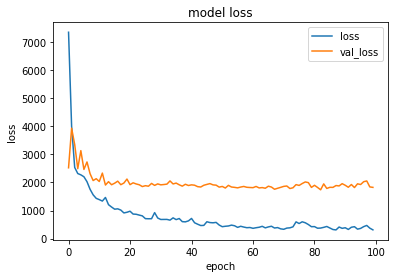

In [134]:
##################################################################################
# Plotten und Speichern der Trainings-History des Modells
################################################################################## 

#plt.plot(training_material_putty.history['loss'])
#plt.plot(training_material_putty.history['val_loss'])
plt.plot(training_material_putty.history['mae'])
plt.plot(training_material_putty.history['val_mae'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'mae', 'val_mae'], loc='upper right')

plt.savefig(destpath_plotsave + 'mae_vs_val_mae.png')
plt.show()


# ##################################################################################
# # Plotten der Trainings-History des Modells
# ##################################################################################
# plt.plot(training_material.history['mae'])
# plt.plot(training_material.history['val_mae'])
# plt.title('Abweichung')
# plt.ylabel('MAE')
# plt.xlabel('Epoche')
# plt.legend(['Training', 'Validierung'], loc='upper left')


# ##################################################################################
# # Speichert den Plot
# ##################################################################################
# plt.savefig(plotsavepath + 'mae_vs_val_mae.png')
# plt.show()



In [135]:
##################################################################################
# Evaluieren der einzelnen Bilder des Trainingsplit per predict
##################################################################################
i = 0
evaluation_train = []
while i < len(x_train_material):

  x = x_train_material[i]
  x = tf.expand_dims(x,axis=0)
  actual_need = y_train_material_putty[i]
  result = material_model.predict(x)
  result = round(result[0][0])
  deviation = abs(actual_need-result)

  row = []
  row.append(images_train_filenames[i])
  row.append(actual_need)
  row.append(result)
  row.append(deviation)

  evaluation_train.append(row)
  i += 1

evaluation_train = sorted(evaluation_train, key=lambda x:x[3])

with open(destpath_logsave + "Evaluation_Train.csv", 'w', newline='', encoding='utf-8-sig') as f_object:  
    writer_object = writer(f_object, delimiter=";")
    writer_object.writerow(["Dateiname", "Tatsächlicher Materialbedarf in g", "geschätzer Materialbedarf in g", "Abweichung Materialbedarf in g"])
    writer_object.writerows(evaluation_train)  
    f_object.close()

In [136]:
##################################################################################
# Evaluieren der einzelnen Bilder des Validationsplit per predict
##################################################################################
i = 0
evaluation_val = []
while i < len(x_val_material):

  x = x_val_material[i]
  x = tf.expand_dims(x,axis=0)
  actual_need = y_val_material_putty[i]
  result = material_model.predict(x)
  result = round(result[0][0])
  deviation = abs(actual_need-result)

  row = []
  row.append(images_val_filenames[i])
  row.append(actual_need)
  row.append(result)
  row.append(deviation)

  evaluation_val.append(row)
  i += 1

evaluation_val = sorted(evaluation_val, key=lambda x:x[3])

with open(destpath_logsave + "Evaluation_Validation.csv", 'w', newline='', encoding='utf-8-sig') as f_object:  
    writer_object = writer(f_object, delimiter=";")
    writer_object.writerow(["Dateiname", "Tatsächlicher Materialbedarf in g", "geschätzer Materialbedarf in g", "Abweichung Materialbedarf in g"])
    writer_object.writerows(evaluation_val)  
    f_object.close()

In [137]:
##################################################################################
# Evaluieren des Modells 
##################################################################################

y_train_material_putty_mae = round(training_material_putty.history['mae'][-1])
y_train_material_putty_share = round((y_train_material_putty_mae / y_train_material_putty_mean), 3)
y_val_material_putty_mae = round(training_material_putty.history['val_mae'][-1])
y_val_material_putty_share = round((y_val_material_putty_mae / y_val_material_putty_mean), 3)

trainingcount = "Training " + str(numberoftraining)
images_format = str(widthquer) + "x" + str(heightquer)  

var_list = [
    date_of_training, #vorher var1
    time_of_training, # vorher var2
    trainingcount, #vorher var3
    model_parameter_total_count, #vorher var4
    modelsize_putty, # vorher var5
    epochs_train, #vorher var6
    standardizing_images, #vorher var7
    preprocesing_images,
    resizing_images,
    waende_alle_count,
    waende_train_count,
    waende_val_count, 
    images_all_count, #vorher var8
    x_train_images_count, #vorher var9
    x_val_images_count, #vorher var10
    images_format,
    y_train_material_putty_mean, #vorher var12
    y_train_material_putty_mae, # vorher var13
    y_train_material_putty_share, # vorher var14
    y_val_material_putty_mean, # vorher var15
    y_val_material_putty_mae, # vorher var16
    y_val_material_putty_share, # vorher var17
]

if os.path.exists(path_eval) == False:
  with open(path_eval, 'w', newline='', encoding='utf-8-sig') as f_object:
    writer_object = writer(f_object, delimiter=";")
    writer_object.writerow(["Trainingsdatum", 
                            "Trainingszeitpunkt", 
                            "Trainingsnummer", 
                            "Anzahl der Parameter des Modells", 
                            "Modellgröße in MB", 
                            "Trainierte Epochen", 
                            "Standardisierung", 
                            "Preprocessing",
                            "Resize", 
                            "Anzahl aller Wände/Szenen", 
                            "Wände Trainingsplit", 
                            "Wände Validationsplit", 
                            "Anzahl aller Bilder", 
                            "Bilder Trainingsplit", 
                            "Bilder Validationsplit", 
                            "Auflösung der Bilder",
                            "Mean Trainingsplit Spachtelmasse", 
                            "Mae Trainingsplit Spachtelmasse", 
                            "Mae/Mean Verhältnis Trainingsplit Spachtelmasse in %", 
                            "Mean Validationsplit Spachtelmasse",
                            "Mae Validationplit Spachtelmasse", 
                            "Mae/Mean Verhältnis Trainingsplit Spachtelmasse in %" 
                            ])

with open(path_eval, 'a', newline='', encoding='utf-8-sig') as f_object:  
  writer_object = writer(f_object, delimiter=";")
  writer_object.writerow(var_list)  
  f_object.close()

In [21]:
%%capture cap_train --no-stderr
with open(destpath_logsave+ "Evaluation_Trainingset_PredictProBild.txt", 'w') as f:
    f.write(cap_train.stdout)

##################################################################################
# Evaluieren des Modells (einzeln per Predict) (Trainingset)
################################################################################## 

# Trainingset
print("Trainingset: ")
print()
i = 0
while i < len(x_train_material):
  print("Bild: "+str(images_train_filenames[i]))
  x = x_train_material[i]
  x = tf.expand_dims(x,axis=0)
  result = material_model.predict(x)
  print("Vorhergesagter Materialbedarf in g: "+str(round(result[0][0])))
  print("Tatsächlicher Materialbedarf in g: "+str(y_train_material_putty[i]))
  print()
  i += 1

In [23]:
%%capture cap_validation --no-stderr
with open(destpath_logsave+ "Evaluation_Validationset_PredictProBild.txt", 'w') as f:
    f.write(cap_validation.stdout)

##################################################################################
# Evaluieren des Modells (einzeln per Predict) (Validation- und Testset)
################################################################################## 

# Validationset
print("Validationset: ")
print()
i = 0
while i < len(x_val_material):
  print("Bild: "+str(images_val_filenames[i]))
  x = x_val_material[i]
  x = tf.expand_dims(x,axis=0)
  result = material_model.predict(x)
  print("Vorhergesagter Materialbedarf in g: "+str(result[0][0]))
  print("Tatsächlicher Materialbedarf in g: "+str(y_val_material_putty[i]))
  print()
  i = i + 1

# Testset
print()
print()
print()
print("Testset: ")
i = 0
while i < len(x_test_material):
  print("Bild: "+str(images_test_filenames[i]))
  x = x_test_material[i]
  x = tf.expand_dims(x,axis=0)
  result = material_model.predict(x)
  print("Vorhergesagter Materialbedarf in g: "+str(result[0][0]))
  print("Tatsächlicher Materialbedarf in g: "+str(y_test_material[i]))
  print()
  i = i + 1

In [13]:
##################################################################################
# Predict
################################################################################## 

srcpath_predict_images = "/content/drive/My Drive/Predict/"

imgToPredict = cv2.imread(srcpath_predict_images+"flugzeug.jpg")
imgToPredict = cv2.resize(imgToPredict, (400, 300), interpolation = cv2.INTER_AREA)
#print(f"Shape before new dimension: {imgToPredict.shape}")
imgToPredict = tf.expand_dims(imgToPredict,axis=0)
#print(f"Shape after new dimension: {imgToPredict.shape}")
result = material_model.predict(imgToPredict)
print("Vorhersage Flugzeugbild: "+str(result))

imgToPredict = cv2.imread(srcpath_predict_images+"auto.jpg")
imgToPredict = cv2.resize(imgToPredict, (400, 300), interpolation = cv2.INTER_AREA)
#print(f"Shape before new dimension: {imgToPredict.shape}")
imgToPredict = tf.expand_dims(imgToPredict,axis=0)
#print(f"Shape after new dimension: {imgToPredict.shape}")
result = material_model.predict(imgToPredict)
print("Vorhersage Autobild: "+str(result))

imgToPredict = cv2.imread(srcpath_predict_images+"gipswand.jpg")
imgToPredict = cv2.resize(imgToPredict, (400, 300), interpolation = cv2.INTER_AREA)
#print(f"Shape before new dimension: {imgToPredict.shape}")
imgToPredict = tf.expand_dims(imgToPredict,axis=0)
#print(f"Shape after new dimension: {imgToPredict.shape}")
result = material_model.predict(imgToPredict)
print("Vorhersage Gipswandbild (Baustelle2 Wand10): "+str(result)+" (Tatsächlicher Materialbedarf = 6627g)")


Vorhersage Flugzeugbild: [[3787.275]]
Vorhersage Autobild: [[4927.784]]
Vorhersage Gipswandbild (Baustelle2 Wand10): [[6433.505]] (Tatsächlicher Materialbedarf = 6627g)


In [16]:
%%capture cap_allgemein --no-stderr
with open(destpath_logsave+ "Evaluation_Allgemein.txt", 'w') as f:
    f.write(cap_allgemein.stdout)

##################################################################################
# Evaluieren des Modells (Allgemein)
################################################################################## 
print("Evaluation Validationset:")
val_material = material_model.evaluate(x_val_material, y_val_material_putty)
print()
print("Evaluation Testset:")
test_material = material_model.evaluate(x_test_material, y_test_material)
